<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [2]:
"""
Import Statements
"""

# Base
from collections import Counter
import re

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [3]:
from explore_data_Copy1 import *
import seaborn as sns
sns.set()

In [4]:
gensim.__version__

'3.8.1'

In [5]:
df = pd.read_csv('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19-Copy1.csv')

In [6]:
df.sample(1)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
28093,AVqkIhxunnc1JgDc3kg_,2017-03-06T14:59:43Z,2019-02-23T02:49:38Z,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,https://www.upccodesearch.com/images/barcode/0...,"amazon/b018t075dc,firehd8tabletwithalexa8hddis...",...,NaN,True,NaN,0.0,5,http://reviews.bestbuy.com/3545/5620410/review...,Love the added space. Easy to move around in. ...,Really love my new Kindle.,sportsmom5,http://reviews.bestbuy.com/3545/5620410/review...


In [7]:
df['reviews.text'] = df['reviews.text'].apply(lambda x: x.lower())

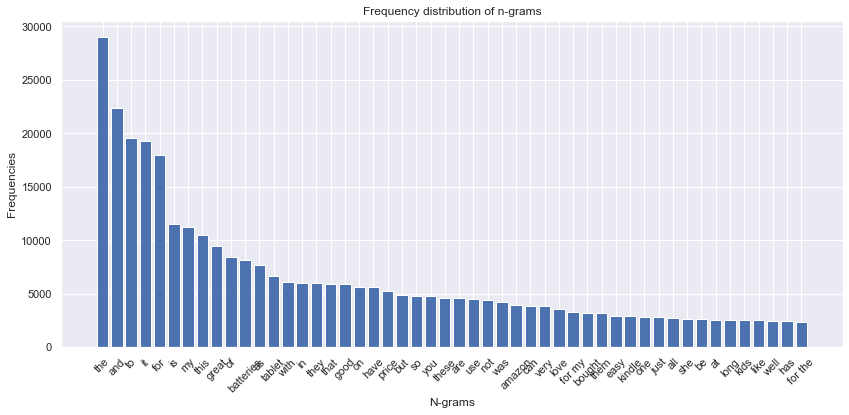

In [8]:
plot_frequency_distribution_of_ngrams(df['reviews.text'],
                                      ngram_range=(1, 2),
                                      num_ngrams=50)

In [9]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [10]:
df['tokens'] = df['reviews.text'].apply(tokenize)

In [11]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [12]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [13]:
STOP_WORDS = nlp.Defaults.stop_words.union(['batteries','I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this',])

In [14]:
tokens = []

for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

In [15]:
df['tokens']

0        [order, 3, item, bad, quality., missing, backu...
1                   [bulk, expensive, way, products, like]
2                                [duracell, price, happy.]
3                             [work, brand, better, price]
4                           [long, lasting, price, great.]
                               ...                        
28327    [got, 2, 8, yr, old, twins., 11, yr, old, bett...
28328    [bought, niece, christmas, gift.she, 9, years,...
28329    [nice, light, internet, browsing,, keeping, em...
28330    [tablet, absolutely, want!, watch, tv, shows, ...
28331    [ninety, dollars,, expectionations, low,, good...
Name: tokens, Length: 28332, dtype: object

In [16]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [17]:
wc = count(df['tokens'])

In [18]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
78,great,7187,8183,1.0,0.023959,0.023959,0.253671
65,good,4633,5148,2.0,0.015073,0.039032,0.163525
7808,tablet,3920,4714,3.0,0.013802,0.052834,0.138359
109,love,3154,3458,4.0,0.010125,0.062958,0.111323
108,use,2881,3233,5.0,0.009466,0.072424,0.101687


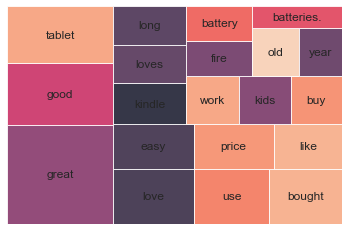

In [19]:
wc = count(df['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [20]:
tokens[3]

['work', 'brand', 'better', 'price']

In [21]:
df.dtypes

id                      object
dateAdded               object
dateUpdated             object
name                    object
asins                   object
brand                   object
categories              object
primaryCategories       object
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
reviews.date            object
reviews.dateSeen        object
reviews.didPurchase     object
reviews.doRecommend     object
reviews.id             float64
reviews.numHelpful     float64
reviews.rating           int64
reviews.sourceURLs      object
reviews.text            object
reviews.title           object
reviews.username        object
sourceURLs              object
tokens                  object
dtype: object

In [22]:
df['reviews.rating']

0        3
1        4
2        5
3        5
4        5
        ..
28327    5
28328    4
28329    5
28330    5
28331    4
Name: reviews.rating, Length: 28332, dtype: int64

In [23]:
df['bad_review'] = df['reviews.rating'] <= 3
df['good_review'] = df['reviews.rating'] >= 4

In [24]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,tokens,bad_review,good_review
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,i order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality., missing, backu...",True,False
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, products, like]",False,True


In [25]:
df['good_review'] = (df['good_review'] == True ).astype(int)

In [26]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,tokens,bad_review,good_review
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,i order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality., missing, backu...",True,0
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, products, like]",False,1


In [27]:
df.good_review.value_counts()

1    25545
0     2787
Name: good_review, dtype: int64

In [28]:
# Let's remove extreme values from the dataset

id2word = corpora.Dictionary(df['tokens'])
id2word.filter_extremes(no_below=5, no_above=0.95)

In [29]:
id2word.token2id['good']

62

In [30]:
id2word.doc2bow(tokenize("This item is expencive"))

[(4, 1)]

In [31]:
import sys
print(sys.getsizeof(id2word))
print(sys.getsizeof(tokens))

56
253632


In [32]:
len(id2word.keys())

5560

In [33]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in df['tokens']]

In [34]:
corpus[225][:10]

[(23, 1),
 (37, 1),
 (44, 1),
 (59, 1),
 (104, 1),
 (127, 1),
 (201, 1),
 (220, 2),
 (237, 1),
 (294, 1)]

In [35]:
%%time
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=12
                  )

CPU times: user 9.14 s, sys: 1.2 s, total: 10.3 s
Wall time: 1min 1s


In [36]:
dir(lda)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'alpha',
 'batch',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offset',
 'optimize_al

In [37]:
lda.print_topics()

[(0,
  '0.097*"great" + 0.026*"long" + 0.021*"product" + 0.021*"easy" + 0.021*"price" + 0.020*"buy" + 0.020*"works" + 0.020*"good" + 0.016*"tablet" + 0.012*"price."'),
 (1,
  '0.040*"great" + 0.022*"tablet" + 0.015*"kids" + 0.013*"year" + 0.013*"case" + 0.013*"apps" + 0.012*"good" + 0.011*"2" + 0.011*"like" + 0.010*"battery"'),
 (2,
  '0.029*"tablet" + 0.022*"great" + 0.017*"kindle" + 0.012*"love" + 0.010*"easy" + 0.009*"like" + 0.009*"user" + 0.009*"read" + 0.009*"screen" + 0.009*"need"'),
 (3,
  '0.037*"love" + 0.028*"price" + 0.025*"great" + 0.016*"like" + 0.016*"read" + 0.011*"size" + 0.010*"good" + 0.010*"kindle" + 0.010*"screen" + 0.009*"easy"'),
 (4,
  '0.030*"great" + 0.022*"can\'t" + 0.018*"best" + 0.017*"value" + 0.014*"beat" + 0.011*"tablet" + 0.011*"love" + 0.011*"-" + 0.009*"thanks" + 0.008*"like"'),
 (5,
  '0.032*"great" + 0.021*"loves" + 0.018*"tablet" + 0.018*"bought" + 0.017*"kindle" + 0.013*"old" + 0.013*"price" + 0.012*"fire" + 0.011*"son" + 0.011*"use"'),
 (6,
  '0.

In [38]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [56]:
topics = [' '.join(t[0:10]) for t in words]

In [57]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
great long product easy price buy works good tablet price.

------ Topic 1 ------
great tablet kids year case apps good 2 like battery

------ Topic 2 ------
tablet great kindle love easy like user read screen need

------ Topic 3 ------
love price great like read size good kindle screen easy

------ Topic 4 ------
great can't best value beat tablet love - thanks like

------ Topic 5 ------
great loves tablet bought kindle old price fire son use

------ Topic 6 ------
year old tablet loves games bought play easy great love

------ Topic 7 ------
love loves great tablet gift easy bought kids perfect daughter

------ Topic 8 ------
easy use loves tablet great bought i'm perfect love lots

------ Topic 9 ------
bought use love purchased easy set parental tablet christmas loved

------ Topic 10 ------
work good batteries. battery use long brand price like better

------ Topic 11 ------
fire kindle new better hd screen bought 8 old 7

------ Topic 12 ------
good tablet

In [58]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [42]:
%%time
pyLDAvis.gensim.prepare(lda, corpus, id2word)
# you can change 'gensim' for 'sklearn'

CPU times: user 17.9 s, sys: 160 ms, total: 18.1 s
Wall time: 21.4 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.165686 -0.014732       1        1  15.110454
0      0.161725  0.127964       2        1   9.549674
14     0.044277 -0.075292       3        1   7.892624
6     -0.158254  0.020116       4        1   7.216490
7     -0.133318  0.060805       5        1   7.050409
2      0.025988 -0.020817       6        1   6.245560
1     -0.016023  0.032103       7        1   6.050344
12     0.078620 -0.062920       8        1   5.936544
11    -0.043653 -0.176576       9        1   5.839010
13    -0.039880 -0.003736      10        1   5.208476
3      0.034052 -0.020308      11        1   4.981923
9     -0.100516  0.044933      12        1   4.889476
8     -0.005027  0.102818      13        1   4.885525
4      0.016736 -0.004187      14        1   4.622989
5     -0.030413 -0.010171      15        1   4.520493, topic_info=         Term         Freq        Total Category  logprob  loglift
62       good  4314.000000  4314.000000  Default  30.0000  30.0000
73      great  7898.000000  7898.000000  Default  29.0000  29.0000
2629    loves  2233.000000  2233.000000  Default  28.0000  28.0000
2982   kindle  2627.000000  2627.000000  Default  27.0000  27.0000
112      year  1739.000000  1739.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
191      time    78.711418  1271.595825  Topic15  -5.1931   0.3143
210      kids    87.078362  2174.112305  Topic15  -5.0921  -0.1210
991      easy    83.558075  3265.690918  Topic15  -5.1334  -0.5691
1037     read    68.461212  1140.601807  Topic15  -5.3326   0.2835
313   product    67.288734  1295.262817  Topic15  -5.3499   0.1391

[1283 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1551      2  0.716308    !
1551      4  0.016467    !
1551      5  0.057634    !
1551      7  0.049401    !
1551     10  0.049401    !
...     ...       ...  ...
4200     10  0.046193   yr
4200     11  0.038494   yr
4200     12  0.304101   yr
4200     13  0.046193   yr
4200     15  0.061590   yr

[4723 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 15, 7, 8, 3, 2, 13, 12, 14, 4, 10, 9, 5, 6])

In [59]:
len(corpus[0])

10

In [60]:
lda[corpus[0]]

[(1, 0.17083204), (3, 0.22905114), (8, 0.14718126), (10, 0.38621452)]

In [61]:
distro = [lda[d] for d in corpus]

In [62]:
distro[3]

[(0, 0.013333522),
 (1, 0.01333347),
 (2, 0.013333472),
 (3, 0.013333499),
 (4, 0.013333475),
 (5, 0.013333483),
 (6, 0.013333471),
 (7, 0.013333468),
 (8, 0.013333475),
 (9, 0.013333468),
 (10, 0.8133313),
 (11, 0.013333487),
 (12, 0.013333485),
 (13, 0.013333471),
 (14, 0.013333475)]

In [63]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [64]:
len(new_distro)

28332

In [65]:
new_distro[0]

{0: 0,
 1: 0.1710166,
 2: 0,
 3: 0.22866186,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0.14770316,
 9: 0,
 10: 0.3858975,
 11: 0,
 12: 0,
 13: 0,
 14: 0}

In [66]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,tokens,bad_review,good_review
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,i order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality., missing, backu...",True,0
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, products, like]",False,1
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,well they are not duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...","[duracell, price, happy.]",False,1
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...","[work, brand, better, price]",False,1
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,these batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...","[long, lasting, price, great.]",False,1


In [68]:
df_d = pd.DataFrame.from_records(new_distro)
df_d.columns = topics
df_d['good_review'] = df.reset_index()['good_review'].tolist()

In [69]:
df_d.head()

,great long product easy price buy works good tablet price.,great tablet kids year case apps good 2 like battery,tablet great kindle love easy like user read screen need,love price great like read size good kindle screen easy,great can't best value beat tablet love - thanks like,great loves tablet bought kindle old price fire son use,year old tablet loves games bought play easy great love,love loves great tablet gift easy bought kids perfect daughter,easy use loves tablet great bought i'm perfect love lots,bought use love purchased easy set parental tablet christmas loved,work good batteries. battery use long brand price like better,fire kindle new better hd screen bought 8 old 7,good tablet price card works use price. buy tablet. sd,kindle great reading easy books bought use playing good fire,tablet google apps play kids good like app use store,good_review
0,0.000000,0.171017,0.000000,0.228662,0.000000,0.000000,0.000000,0.000000,0.147703,0.000000,0.385897,0.000000,0.000000,0.000000,0.000000,0
1,0.844432,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,1
2,0.016670,0.016669,0.016669,0.016670,0.016669,0.016670,0.016669,0.016669,0.330801,0.016669,0.452495,0.016669,0.016670,0.016669,0.016670,1
3,0.013334,0.013333,0.013333,0.013334,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.813331,0.013333,0.013333,0.013333,0.013333,1
4,0.813330,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,0.013334,1


In [70]:
df_d.groupby('good_review').mean()

,great long product easy price buy works good tablet price.,great tablet kids year case apps good 2 like battery,tablet great kindle love easy like user read screen need,love price great like read size good kindle screen easy,great can't best value beat tablet love - thanks like,great loves tablet bought kindle old price fire son use,year old tablet loves games bought play easy great love,love loves great tablet gift easy bought kids perfect daughter,easy use loves tablet great bought i'm perfect love lots,bought use love purchased easy set parental tablet christmas loved,work good batteries. battery use long brand price like better,fire kindle new better hd screen bought 8 old 7,good tablet price card works use price. buy tablet. sd,kindle great reading easy books bought use playing good fire,tablet google apps play kids good like app use store
good_review,,,,,,,,,,,,,,,
0,0.086960,0.045627,0.065810,0.023945,0.039420,0.031132,0.042894,0.026888,0.038272,0.065031,0.267397,0.047577,0.060642,0.028972,0.084903
1,0.152433,0.045881,0.044607,0.050131,0.047974,0.041169,0.064934,0.084232,0.051701,0.043721,0.121281,0.044457,0.065378,0.049024,0.042549


## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling